# Detecting Sports using PyTorch

Image classification of sports images into one of over 100 classes of sport.

Notebook adapted from the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [here](https://www.kaggle.com/datasets/gpiosenka/sports-classification/versions/8](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.11.0+cpu


# Preparing Training and Test Sets

In [2]:
class_names = [name for name in os.listdir("../input/sports-classification/test")]

root_dir = '../input/sports-classification'
source_dirs = class_names

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('jpg')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [3]:
class SportsDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('jpg')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = class_names
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [5]:

train_dirs = {    
}
for c in class_names:
    train_dirs[c] = os.path.join('../input/sports-classification/train', c)


train_dataset = SportsDataset(train_dirs, train_transform)

Found 138 bobsled examples
Found 137 hurdles examples
Found 117 snow boarding examples
Found 134 fly fishing examples
Found 127 luge examples
Found 135 sidecar racing examples
Found 112 ampute football examples
Found 147 volleyball examples
Found 145 billiards examples
Found 151 giant slalom examples
Found 131 tennis examples
Found 139 horse racing examples
Found 112 pole dancing examples
Found 159 figure skating women examples
Found 159 rollerblade racing examples
Found 135 fencing examples
Found 167 olympic wrestling examples
Found 157 golf examples
Found 99 ultimate examples
Found 147 harness racing examples
Found 191 football examples
Found 133 frisbee examples
Found 125 bungee jumping examples
Found 155 shot put examples
Found 130 ice climbing examples
Found 146 figure skating men examples
Found 143 rowing examples
Found 111 bike polo examples
Found 157 swimming examples
Found 150 judo examples
Found 113 axe throwing examples
Found 132 archery examples
Found 174 baseball examples


In [6]:
test_dirs = {}
for c in [name for name in os.listdir("../input/sports-classification/test")]:
    test_dirs[c] = os.path.join('../input/sports-classification/test', c)
test_dataset = SportsDataset(test_dirs, test_transform)

Found 5 bobsled examples
Found 5 hurdles examples
Found 5 snow boarding examples
Found 5 fly fishing examples
Found 5 luge examples
Found 5 sidecar racing examples
Found 5 ampute football examples
Found 5 volleyball examples
Found 5 billiards examples
Found 5 giant slalom examples
Found 5 tennis examples
Found 5 horse racing examples
Found 5 pole dancing examples
Found 5 figure skating women examples
Found 5 rollerblade racing examples
Found 5 fencing examples
Found 5 olympic wrestling examples
Found 5 golf examples
Found 5 ultimate examples
Found 5 harness racing examples
Found 5 football examples
Found 5 frisbee examples
Found 5 bungee jumping examples
Found 5 shot put examples
Found 5 ice climbing examples
Found 5 figure skating men examples
Found 5 rowing examples
Found 5 bike polo examples
Found 5 swimming examples
Found 5 judo examples
Found 5 axe throwing examples
Found 5 archery examples
Found 5 baseball examples
Found 5 wheelchair basketball examples
Found 5 log rolling exampl

In [7]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2262
Number of test batches 84


# Data Visualization

In [8]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

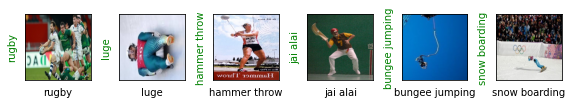

In [9]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

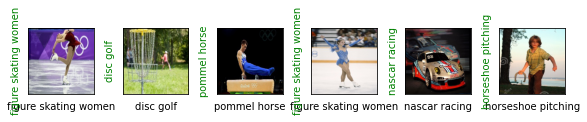

In [10]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [11]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=len(class_names))
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.01)

In [13]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

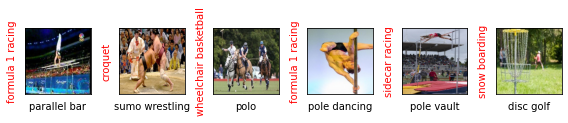

In [14]:
show_preds()

# Training the Model

In [15]:
from tqdm.notebook import tqdm, trange
def train(epochs):
    print('Starting training..')
    for e in trange(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 200 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..


  0%|          | 0/2 [00:00<?, ?it/s]

Starting epoch 1/2
Evaluating at step 0
Validation Loss: 906.8117, Accuracy: 0.0040


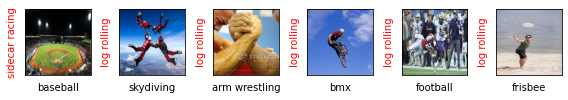

Evaluating at step 200
Validation Loss: 15.4517, Accuracy: 0.0140


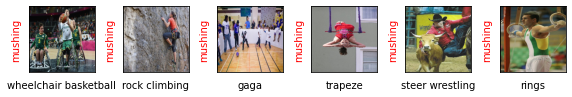

Evaluating at step 400
Validation Loss: 5.0126, Accuracy: 0.0140


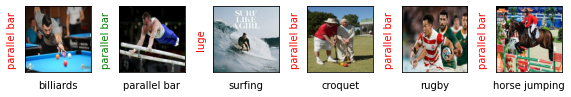

Evaluating at step 600
Validation Loss: 4.6420, Accuracy: 0.0160


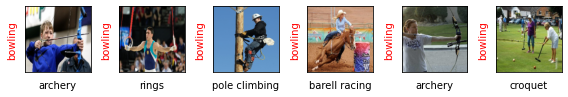

Evaluating at step 800
Validation Loss: 4.6657, Accuracy: 0.0080


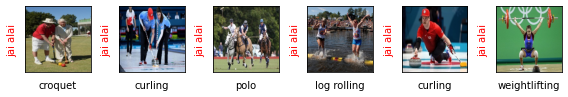

Evaluating at step 1000
Validation Loss: 4.6730, Accuracy: 0.0180


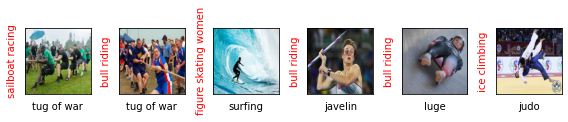

Evaluating at step 1200
Validation Loss: 4.5083, Accuracy: 0.0160


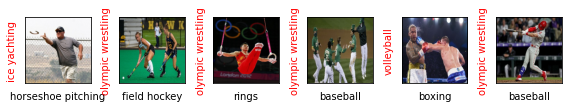

Evaluating at step 1400
Validation Loss: 4.4267, Accuracy: 0.0340


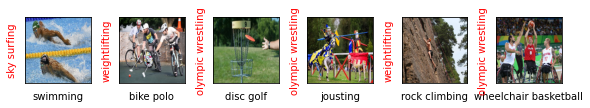

Evaluating at step 1600
Validation Loss: 4.4017, Accuracy: 0.0380


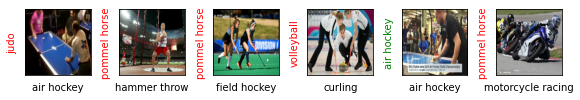

Evaluating at step 1800
Validation Loss: 4.4829, Accuracy: 0.0160


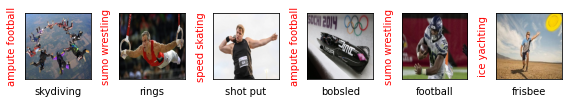

Evaluating at step 2000
Validation Loss: 4.3531, Accuracy: 0.0320


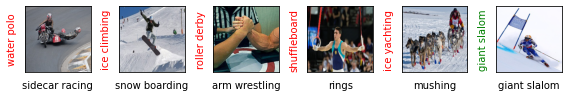

Evaluating at step 2200
Validation Loss: 4.2818, Accuracy: 0.0440


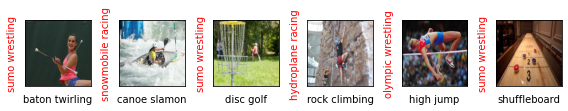

Training Loss: 4.5842
Starting epoch 2/2
Evaluating at step 0
Validation Loss: 4.3394, Accuracy: 0.0520


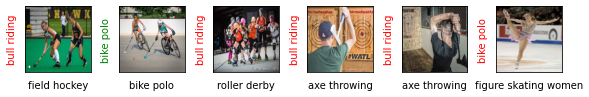

Evaluating at step 200
Validation Loss: 4.3118, Accuracy: 0.0400


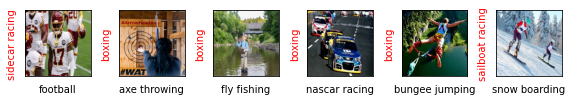

Evaluating at step 400
Validation Loss: 4.2605, Accuracy: 0.0680


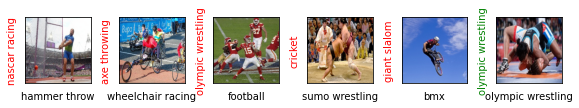

Evaluating at step 600
Validation Loss: 4.2500, Accuracy: 0.0480


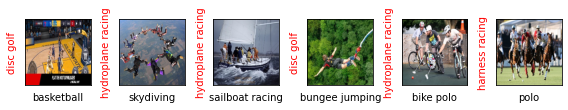

Evaluating at step 800
Validation Loss: 4.1269, Accuracy: 0.0380


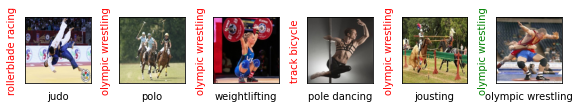

Evaluating at step 1000
Validation Loss: 4.1830, Accuracy: 0.0640


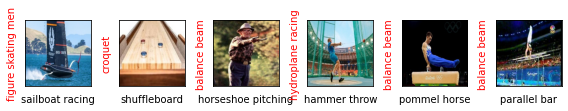

Evaluating at step 1200
Validation Loss: 4.1359, Accuracy: 0.0660


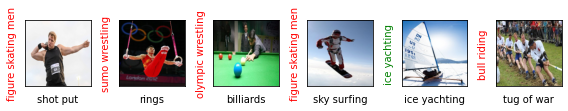

Evaluating at step 1400
Validation Loss: 4.1267, Accuracy: 0.0380


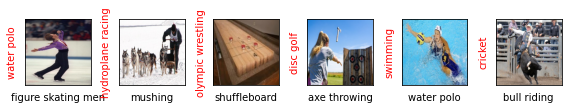

Evaluating at step 1600
Validation Loss: 4.0082, Accuracy: 0.0620


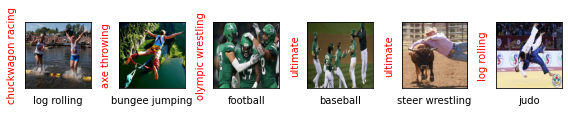

Evaluating at step 1800
Validation Loss: 4.3182, Accuracy: 0.0260


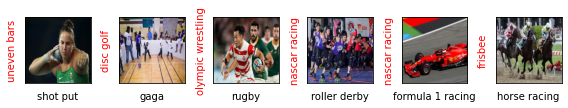

Evaluating at step 2000
Validation Loss: 3.9884, Accuracy: 0.0720


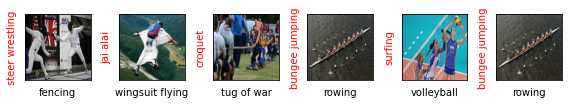

Evaluating at step 2200
Validation Loss: 4.1836, Accuracy: 0.0740


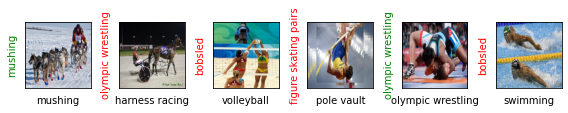

Training Loss: 4.1963
Training complete..
CPU times: user 2h 8min 7s, sys: 53.4 s, total: 2h 9min 1s
Wall time: 1h 6min 7s


In [16]:
%%time

train(epochs=2)

# Final Results

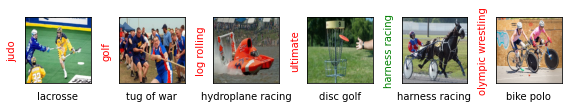

In [17]:
show_preds()

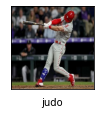

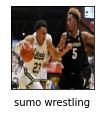

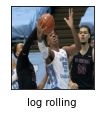

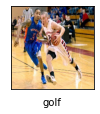

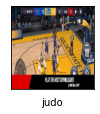

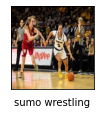

In [18]:
predict_dir = '../input/sports-classification/images to predict'
images = os.listdir(predict_dir)
predict_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



#images = [Image.open(os.path.join(predict_dir, i)).convert('RGB') for i in images]
for i in images:
    image = Image.open(os.path.join(predict_dir, i)).convert('RGB')
    image = predict_transform(image)
    image = image.unsqueeze(0)

    outputs = resnet18(image)
    _, preds = torch.max(outputs, 1)
    plt.figure(figsize=(8, 4))

    image = image.squeeze(0)
    plt.subplot(1, 6,1, xticks=[], yticks=[])
    image = image.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    image = np.clip(image, 0., 1.)
    plt.imshow(image)
    plt.xlabel(f'{class_names[int(preds[0].numpy())]}')
    plt.tight_layout()
    plt.show()
    

